## setup env

In [ ]:
%load_ext autoreload
%autoreload 2

## External lib
import matplotlib.pyplot as plt
import torch
import sys
import os

from torchvision import transforms
from torch import nn, optim

## Setup working env
PATH_REPO_DRIVE = ''

try:
    import google.colab
    IN_COLAB = True
    PATH_REPO_DRIVE = 'drive/MyDrive/colab/entretien/cat-vs-dog'
except:
    IN_COLAB = False

if IN_COLAB and os.getcwd()=='/content':
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(PATH_REPO_DRIVE)

device = torch.device(
    'cuda:0' if torch.cuda.is_available() else 'cpu'
)

In [71]:
## Internal lib
from dataset.cat_dog_dataset import CatDogDataloader, plot_images
from model.resnet import ResNet18, ResNet34, ResNet50
from utils.trainer import Trainer

In [ ]:
## Download data
%%capture
os.system(f"bash {PATH_REPO_DRIVE}/setup_data.sh")

# dataloader pipeline

In [64]:
NUM_CHANNEL = 3
IMG_SIZE = 512
BATCH_SIZE = 16

custom_transform = transforms.Compose(
    [
        transforms.RandomPerspective(distortion_scale=.4, p=.5),
        transforms.Resize(
            (int(IMG_SIZE*2), int(IMG_SIZE*2))
        ),
        transforms.RandomHorizontalFlip(p=.5),
        transforms.RandomCrop(IMG_SIZE),
        transforms.RandomRotation(15),
        
        # added
        transforms.ColorJitter(
            brightness=.4,
            contrast=.4,
            saturation=.4,
            hue=.2
        ),

        transforms.ToTensor(),
        transforms.Normalize(mean=(0,0,0), std=(1,1,1))
    ]
)


dataloader = CatDogDataloader(
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    dataset_root = 'cats_and_dogs_filtered',
    custom_transform = custom_transform
)

In [65]:
images, _ = iter(dataloader.train_iterator).next()
plot_images(images, 'cat & dog - train', PATH_REPO_DRIVE)

images, _ = iter(dataloader.valid_iterator).next()
plot_images(images, 'cat & dog - valid')

images, _ = iter(dataloader.test_iterator).next()
plot_images(images, 'cat & dog - test', PATH_REPO_DRIVE)

Output hidden; open in https://colab.research.google.com to view.

# model

In [72]:
class Classifier(ResNet18):
    def __init__(self, num_classes=1):
        super(Classifier, self).__init__(num_classes=num_classes)
        
        self.fc = nn.Sequential(
            nn.Linear(512*self.block.expansion, num_classes, bias=True),
            nn.Sigmoid() if num_classes==1 else nn.Softmax()
        )

model = Classifier(num_classes=1)

In [73]:
model.summary(device, input_dim=(NUM_CHANNEL,IMG_SIZE,IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
    ResidualBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

# training

In [ ]:
## optimizer
lambda x: optim.SGD(x, momentum=0.9)

## scheduler
# - cyclic
lambda x: optim.lr_scheduler.CyclicLR(x, base_lr=0.01, max_lr=0.1)

In [75]:
trainer = Trainer(
    model=model,
    dataloader=dataloader,
    lr=1e-4,
    criterion=nn.BCELoss(),
    optimizer=optim.Adam,
    scheduler=lambda x: optim.lr_scheduler.StepLR(x, step_size=5, gamma=.5),
    device=device,
    root=''
)

In [76]:
trainer.train_data(num_epochs=300)

Epoch: 0


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.7030 Acc : 55.9181 Time: 70.0184
Valid - Loss : 0.6659 Acc : 60.0962 Time: 2.4344

Epoch: 1


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6923 Acc : 56.8031 Time: 66.9928
Valid - Loss : 0.6652 Acc : 60.5769 Time: 2.6264

Epoch: 2


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6758 Acc : 56.6925 Time: 68.1199
Valid - Loss : 0.6832 Acc : 55.7692 Time: 2.4634

Epoch: 3


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6731 Acc : 58.7389 Time: 66.0338
Valid - Loss : 0.6702 Acc : 60.0962 Time: 2.4794

Epoch: 4


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6692 Acc : 59.0155 Time: 66.9912
Valid - Loss : 0.6431 Acc : 64.9038 Time: 2.3903

Epoch: 5


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6690 Acc : 59.7898 Time: 65.9061
Valid - Loss : 0.6640 Acc : 61.0577 Time: 2.4168

Epoch: 6


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6672 Acc : 60.2876 Time: 66.1376
Valid - Loss : 0.6667 Acc : 52.4038 Time: 2.4263

Epoch: 7


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6594 Acc : 60.5642 Time: 67.1324
Valid - Loss : 0.6495 Acc : 62.0192 Time: 2.4849

Epoch: 8


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6535 Acc : 61.6704 Time: 65.4102
Valid - Loss : 0.6526 Acc : 61.0577 Time: 2.4286

Epoch: 9


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6385 Acc : 63.8274 Time: 67.5045
Valid - Loss : 0.5862 Acc : 67.7885 Time: 2.4482

Epoch: 10


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6397 Acc : 63.2743 Time: 64.2583
Valid - Loss : 0.6521 Acc : 62.5000 Time: 2.4130

Epoch: 11


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6306 Acc : 65.3761 Time: 66.9329
Valid - Loss : 0.6163 Acc : 65.8654 Time: 2.4825

Epoch: 12


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6150 Acc : 66.5929 Time: 65.9361
Valid - Loss : 0.6048 Acc : 71.1538 Time: 2.4571

Epoch: 13


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6240 Acc : 65.7633 Time: 66.9234
Valid - Loss : 0.6150 Acc : 66.8269 Time: 2.3991

Epoch: 14


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6048 Acc : 67.3673 Time: 64.4551
Valid - Loss : 0.5961 Acc : 66.8269 Time: 2.4459

Epoch: 15


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5999 Acc : 68.4181 Time: 66.3369
Valid - Loss : 0.6222 Acc : 61.5385 Time: 2.4411

Epoch: 16


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5867 Acc : 68.6947 Time: 68.1543
Valid - Loss : 0.5454 Acc : 73.5577 Time: 2.4266

Epoch: 17


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5724 Acc : 69.9115 Time: 65.9395
Valid - Loss : 0.5271 Acc : 75.0000 Time: 2.4401

Epoch: 18


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5855 Acc : 69.9115 Time: 67.8786
Valid - Loss : 0.5538 Acc : 73.0769 Time: 2.4048

Epoch: 19


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5597 Acc : 71.5155 Time: 64.6690
Valid - Loss : 0.5573 Acc : 73.0769 Time: 2.5068

Epoch: 20


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5706 Acc : 69.7456 Time: 66.3875
Valid - Loss : 0.5512 Acc : 76.4423 Time: 2.4575

Epoch: 21


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5708 Acc : 70.9624 Time: 64.7187
Valid - Loss : 0.5681 Acc : 70.1923 Time: 2.4443

Epoch: 22


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5648 Acc : 70.7965 Time: 67.0137
Valid - Loss : 0.5657 Acc : 73.0769 Time: 2.3906

Epoch: 23


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5531 Acc : 71.6814 Time: 66.0146
Valid - Loss : 0.5741 Acc : 68.7500 Time: 3.8874

Epoch: 24


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5468 Acc : 72.7323 Time: 64.7680
Valid - Loss : 0.5610 Acc : 66.8269 Time: 2.4005

Epoch: 25


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5462 Acc : 73.1748 Time: 66.6908
Valid - Loss : 0.5301 Acc : 75.0000 Time: 2.4711

Epoch: 26


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5297 Acc : 72.7876 Time: 64.4318
Valid - Loss : 0.5726 Acc : 68.7500 Time: 2.3502

Epoch: 27


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5352 Acc : 72.4004 Time: 65.9373
Valid - Loss : 0.5510 Acc : 71.6346 Time: 2.4115

Epoch: 28


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5120 Acc : 75.7190 Time: 65.0536
Valid - Loss : 0.5013 Acc : 75.4808 Time: 2.3997

Epoch: 29


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5149 Acc : 74.9447 Time: 65.9351
Valid - Loss : 0.4696 Acc : 79.8077 Time: 2.3567

Epoch: 30


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5193 Acc : 74.5575 Time: 65.2452
Valid - Loss : 0.4992 Acc : 73.5577 Time: 2.4483

Epoch: 31


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5140 Acc : 75.1106 Time: 67.0083
Valid - Loss : 0.4750 Acc : 75.0000 Time: 2.4613

Epoch: 32


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5045 Acc : 74.3363 Time: 64.2389
Valid - Loss : 0.5567 Acc : 73.0769 Time: 3.8251

Epoch: 33


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4629 Acc : 77.3783 Time: 65.2682
Valid - Loss : 0.4990 Acc : 76.9231 Time: 2.3811

Epoch: 34


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4945 Acc : 75.5531 Time: 66.7306
Valid - Loss : 0.5013 Acc : 73.0769 Time: 2.3663

Epoch: 35


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4829 Acc : 77.0465 Time: 64.5486
Valid - Loss : 0.5162 Acc : 73.5577 Time: 2.4396

Epoch: 36


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4696 Acc : 78.0420 Time: 66.9976
Valid - Loss : 0.5103 Acc : 75.9615 Time: 2.4286

Epoch: 37


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4645 Acc : 77.5996 Time: 65.5509
Valid - Loss : 0.5335 Acc : 76.9231 Time: 2.4188

Epoch: 38


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4564 Acc : 78.2633 Time: 65.7793
Valid - Loss : 0.5096 Acc : 75.9615 Time: 2.3916

Epoch: 39


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4656 Acc : 78.8164 Time: 64.5801
Valid - Loss : 0.4428 Acc : 79.3269 Time: 2.3724

Epoch: 40


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4486 Acc : 79.1482 Time: 66.7012
Valid - Loss : 0.4513 Acc : 77.8846 Time: 2.4044

Epoch: 41


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4531 Acc : 79.2035 Time: 64.9779
Valid - Loss : 0.4255 Acc : 83.6538 Time: 3.7355

Epoch: 42


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4470 Acc : 80.1438 Time: 64.6399
Valid - Loss : 0.4803 Acc : 77.4038 Time: 2.4008

Epoch: 43


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4254 Acc : 79.5907 Time: 66.8181
Valid - Loss : 0.4148 Acc : 79.8077 Time: 2.3377

Epoch: 44


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4335 Acc : 80.6416 Time: 63.3475
Valid - Loss : 0.4575 Acc : 80.7692 Time: 2.3764

Epoch: 45


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4171 Acc : 81.2500 Time: 65.7620
Valid - Loss : 0.4085 Acc : 81.2500 Time: 2.4301

Epoch: 46


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4194 Acc : 81.8031 Time: 64.9423
Valid - Loss : 0.4057 Acc : 82.2115 Time: 2.3903

Epoch: 47


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4052 Acc : 80.9735 Time: 66.3452
Valid - Loss : 0.4446 Acc : 81.2500 Time: 2.3706

Epoch: 48


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4111 Acc : 82.3562 Time: 63.4051
Valid - Loss : 0.4028 Acc : 82.2115 Time: 2.3434

Epoch: 49


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4039 Acc : 82.1350 Time: 66.3667
Valid - Loss : 0.4503 Acc : 81.7308 Time: 2.4141

Epoch: 50


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3829 Acc : 83.1305 Time: 65.3443
Valid - Loss : 0.4171 Acc : 79.8077 Time: 2.4442

Epoch: 51


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3866 Acc : 83.5177 Time: 64.8113
Valid - Loss : 0.3689 Acc : 84.1346 Time: 2.4226

Epoch: 52


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3716 Acc : 84.0708 Time: 64.4234
Valid - Loss : 0.4464 Acc : 79.8077 Time: 2.4398

Epoch: 53


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3877 Acc : 83.1305 Time: 66.6734
Valid - Loss : 0.5104 Acc : 76.9231 Time: 2.4093

Epoch: 54


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3864 Acc : 83.6283 Time: 64.8599
Valid - Loss : 0.4470 Acc : 80.2885 Time: 3.3746

Epoch: 55


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3578 Acc : 84.5686 Time: 64.8522
Valid - Loss : 0.5324 Acc : 77.8846 Time: 2.3890

Epoch: 56


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3655 Acc : 83.4624 Time: 66.9081
Valid - Loss : 0.3514 Acc : 86.0577 Time: 2.3590

Epoch: 57


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3662 Acc : 83.6836 Time: 64.7552
Valid - Loss : 0.3620 Acc : 85.5769 Time: 2.4442

Epoch: 58


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3484 Acc : 84.5686 Time: 65.5535
Valid - Loss : 0.4667 Acc : 80.2885 Time: 2.4493

Epoch: 59


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3523 Acc : 84.7898 Time: 64.5886
Valid - Loss : 0.4055 Acc : 83.1731 Time: 2.3739

Epoch: 60


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3425 Acc : 85.2323 Time: 65.5412
Valid - Loss : 0.3592 Acc : 81.7308 Time: 2.3687

Epoch: 61


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3695 Acc : 83.0752 Time: 64.5375
Valid - Loss : 0.3481 Acc : 83.1731 Time: 2.4077

Epoch: 62


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3261 Acc : 85.8960 Time: 66.1398
Valid - Loss : 0.3579 Acc : 84.1346 Time: 2.3993

Epoch: 63


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3227 Acc : 86.0066 Time: 64.8814
Valid - Loss : 0.3412 Acc : 83.1731 Time: 2.3888

Epoch: 64


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3313 Acc : 84.7345 Time: 66.1808
Valid - Loss : 0.4875 Acc : 77.8846 Time: 2.4718

Epoch: 65


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3314 Acc : 85.6748 Time: 65.0212
Valid - Loss : 0.4469 Acc : 80.7692 Time: 2.4382

Epoch: 66


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3191 Acc : 86.6704 Time: 65.8258
Valid - Loss : 0.4343 Acc : 80.7692 Time: 2.3975

Epoch: 67


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3359 Acc : 85.7301 Time: 65.1092
Valid - Loss : 0.5519 Acc : 79.3269 Time: 2.4708

Epoch: 68


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3459 Acc : 84.7898 Time: 66.7289
Valid - Loss : 0.3254 Acc : 86.0577 Time: 2.3903

Epoch: 69


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2998 Acc : 86.9469 Time: 65.6814
Valid - Loss : 0.3871 Acc : 81.7308 Time: 3.7319

Epoch: 70


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3132 Acc : 86.4491 Time: 65.4904
Valid - Loss : 0.3491 Acc : 84.6154 Time: 2.4531

Epoch: 71


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3166 Acc : 87.0022 Time: 66.5089
Valid - Loss : 0.4120 Acc : 83.1731 Time: 2.4907

Epoch: 72


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3062 Acc : 86.0066 Time: 66.8976
Valid - Loss : 0.3715 Acc : 83.6538 Time: 2.5691

Epoch: 73


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2929 Acc : 88.1084 Time: 67.7601
Valid - Loss : 0.3026 Acc : 87.0192 Time: 2.4043

Epoch: 74


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3058 Acc : 87.2788 Time: 65.3201
Valid - Loss : 0.3720 Acc : 86.0577 Time: 2.3996

Epoch: 75


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3032 Acc : 86.4491 Time: 66.8835
Valid - Loss : 0.3827 Acc : 84.6154 Time: 2.4270

Epoch: 76


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3158 Acc : 86.3385 Time: 66.2643
Valid - Loss : 0.3703 Acc : 83.1731 Time: 2.4613

Epoch: 77


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2784 Acc : 88.6062 Time: 66.3151
Valid - Loss : 0.3624 Acc : 82.2115 Time: 2.4032

Epoch: 78


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3018 Acc : 87.4447 Time: 66.7607
Valid - Loss : 0.3998 Acc : 82.2115 Time: 2.5035

Epoch: 79


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2748 Acc : 88.5509 Time: 67.0367
Valid - Loss : 0.3787 Acc : 85.5769 Time: 2.4561

Epoch: 80


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2745 Acc : 87.5000 Time: 68.3523
Valid - Loss : 0.3803 Acc : 82.6923 Time: 2.5114

Epoch: 81


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2750 Acc : 89.4912 Time: 65.2830
Valid - Loss : 0.3191 Acc : 84.1346 Time: 2.4166

Epoch: 82


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2799 Acc : 88.9934 Time: 67.2323
Valid - Loss : 0.3499 Acc : 83.1731 Time: 2.5082

Epoch: 83


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2600 Acc : 89.0487 Time: 64.9823
Valid - Loss : 0.4118 Acc : 85.0962 Time: 2.4393

Epoch: 84


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2776 Acc : 87.5553 Time: 68.0554
Valid - Loss : 0.3943 Acc : 83.1731 Time: 2.4181

Epoch: 85


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2442 Acc : 89.1040 Time: 64.9084
Valid - Loss : 0.3434 Acc : 86.0577 Time: 2.3752

Epoch: 86


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2675 Acc : 89.4358 Time: 66.2754
Valid - Loss : 0.3808 Acc : 83.6538 Time: 2.4326

Epoch: 87


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2885 Acc : 87.6106 Time: 64.9579
Valid - Loss : 0.4086 Acc : 86.0577 Time: 2.4377

Epoch: 88


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2493 Acc : 90.5420 Time: 67.5320
Valid - Loss : 0.3058 Acc : 85.0962 Time: 2.4369

Epoch: 89


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2425 Acc : 89.5465 Time: 64.0823
Valid - Loss : 0.3064 Acc : 87.9808 Time: 2.3997

Epoch: 90


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2476 Acc : 90.1549 Time: 66.4935
Valid - Loss : 0.3885 Acc : 81.2500 Time: 2.4333

Epoch: 91


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2596 Acc : 89.3252 Time: 65.1601
Valid - Loss : 0.3642 Acc : 82.6923 Time: 2.3621

Epoch: 92


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2399 Acc : 90.3761 Time: 65.8042
Valid - Loss : 0.3770 Acc : 87.0192 Time: 2.4103

Epoch: 93


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2308 Acc : 90.7080 Time: 66.6816
Valid - Loss : 0.3439 Acc : 84.6154 Time: 2.3961

Epoch: 94


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2675 Acc : 88.7168 Time: 64.2418
Valid - Loss : 0.4444 Acc : 83.1731 Time: 2.4037

Epoch: 95


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2023 Acc : 91.7035 Time: 66.3966
Valid - Loss : 0.3279 Acc : 87.5000 Time: 2.4310

Epoch: 96


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2313 Acc : 89.7124 Time: 64.8747
Valid - Loss : 0.4552 Acc : 83.6538 Time: 2.3543

Epoch: 97


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2482 Acc : 89.6571 Time: 66.2193
Valid - Loss : 0.4799 Acc : 80.2885 Time: 2.4914

Epoch: 98


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2450 Acc : 90.0442 Time: 65.1852
Valid - Loss : 0.3652 Acc : 87.9808 Time: 2.4241

Epoch: 99


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2196 Acc : 90.8186 Time: 66.4209
Valid - Loss : 0.3547 Acc : 83.6538 Time: 2.3965

Epoch: 100


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2395 Acc : 90.1549 Time: 65.2382
Valid - Loss : 0.3223 Acc : 85.0962 Time: 2.4015

Epoch: 101


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2185 Acc : 90.9292 Time: 66.2352
Valid - Loss : 0.3280 Acc : 86.0577 Time: 2.4092

Epoch: 102


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2396 Acc : 90.3208 Time: 63.8405
Valid - Loss : 0.3978 Acc : 87.5000 Time: 2.5185

Epoch: 103


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2137 Acc : 91.7588 Time: 66.2047
Valid - Loss : 0.3916 Acc : 83.6538 Time: 2.4208

Epoch: 104


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2325 Acc : 90.4314 Time: 64.2091
Valid - Loss : 0.4281 Acc : 85.0962 Time: 2.3772

Epoch: 105


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2172 Acc : 91.0398 Time: 65.7852
Valid - Loss : 0.3854 Acc : 84.1346 Time: 2.3812

Epoch: 106


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2146 Acc : 91.2058 Time: 64.4999
Valid - Loss : 0.2843 Acc : 89.4231 Time: 2.3801

Epoch: 107


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2130 Acc : 91.2058 Time: 66.6948
Valid - Loss : 0.3239 Acc : 85.5769 Time: 2.4073

Epoch: 108


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2477 Acc : 88.7168 Time: 64.0654
Valid - Loss : 0.3688 Acc : 84.6154 Time: 2.4701

Epoch: 109


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2046 Acc : 91.9248 Time: 66.3332
Valid - Loss : 0.3414 Acc : 85.5769 Time: 2.3573

Epoch: 110


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1933 Acc : 91.9248 Time: 65.4593
Valid - Loss : 0.3623 Acc : 86.5385 Time: 2.9226

Epoch: 111


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2156 Acc : 91.9801 Time: 66.2249
Valid - Loss : 0.2944 Acc : 86.5385 Time: 2.4582

Epoch: 112


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2128 Acc : 91.7588 Time: 65.9002
Valid - Loss : 0.3881 Acc : 84.1346 Time: 2.4303

Epoch: 113


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2133 Acc : 91.1504 Time: 65.1908
Valid - Loss : 0.3401 Acc : 86.0577 Time: 2.4518

Epoch: 114


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1987 Acc : 92.2566 Time: 67.1399
Valid - Loss : 0.3832 Acc : 85.0962 Time: 2.4568

Epoch: 115


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1864 Acc : 92.4779 Time: 64.3092
Valid - Loss : 0.3182 Acc : 87.5000 Time: 2.3595

Epoch: 116


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1813 Acc : 92.5885 Time: 66.4988
Valid - Loss : 0.3433 Acc : 85.0962 Time: 2.3677

Epoch: 117


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2050 Acc : 91.0398 Time: 63.7406
Valid - Loss : 0.3645 Acc : 86.5385 Time: 2.3719

Epoch: 118


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1855 Acc : 92.5332 Time: 65.5783
Valid - Loss : 0.2838 Acc : 89.4231 Time: 2.4507

Epoch: 119


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2091 Acc : 91.9801 Time: 64.7886
Valid - Loss : 0.2813 Acc : 89.4231 Time: 2.4813

Epoch: 120


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1599 Acc : 92.9757 Time: 66.8185
Valid - Loss : 0.3460 Acc : 87.5000 Time: 2.4208

Epoch: 121


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1801 Acc : 93.0863 Time: 65.0088
Valid - Loss : 0.3177 Acc : 90.3846 Time: 2.4511

Epoch: 122


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2043 Acc : 91.7035 Time: 67.7578
Valid - Loss : 0.3263 Acc : 86.5385 Time: 2.5091

Epoch: 123


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1890 Acc : 91.7588 Time: 65.9419
Valid - Loss : 0.4049 Acc : 85.0962 Time: 2.4461

Epoch: 124


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1775 Acc : 92.8650 Time: 66.7721
Valid - Loss : 0.2718 Acc : 88.4615 Time: 2.4234

Epoch: 125


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1770 Acc : 92.8650 Time: 65.9933
Valid - Loss : 0.3115 Acc : 88.9423 Time: 2.4908

Epoch: 126


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1745 Acc : 93.3628 Time: 67.3403
Valid - Loss : 0.4022 Acc : 86.5385 Time: 2.4617

Epoch: 127


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1837 Acc : 93.0863 Time: 68.5821
Valid - Loss : 0.2847 Acc : 87.5000 Time: 2.4604

Epoch: 128


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1911 Acc : 92.7544 Time: 68.6637
Valid - Loss : 0.3702 Acc : 86.5385 Time: 2.5833

Epoch: 129


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1773 Acc : 92.8097 Time: 67.8787
Valid - Loss : 0.2691 Acc : 90.8654 Time: 2.5305

Epoch: 130


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1879 Acc : 92.5332 Time: 66.7976
Valid - Loss : 0.3159 Acc : 88.4615 Time: 2.4363

Epoch: 131


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1583 Acc : 93.8053 Time: 67.7441
Valid - Loss : 0.3232 Acc : 86.0577 Time: 2.5004

Epoch: 132


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1840 Acc : 92.5332 Time: 65.4890
Valid - Loss : 0.2747 Acc : 87.9808 Time: 2.4920

Epoch: 133


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1679 Acc : 93.5288 Time: 67.7928
Valid - Loss : 0.3782 Acc : 84.1346 Time: 2.4873

Epoch: 134


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1559 Acc : 93.7500 Time: 66.1790
Valid - Loss : 0.3764 Acc : 87.0192 Time: 2.4823

Epoch: 135


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1687 Acc : 93.6947 Time: 67.0180
Valid - Loss : 0.3407 Acc : 87.9808 Time: 2.4180

Epoch: 136


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1547 Acc : 93.8053 Time: 65.9097
Valid - Loss : 0.3211 Acc : 88.4615 Time: 2.4270

Epoch: 137


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1781 Acc : 92.9757 Time: 66.1017
Valid - Loss : 0.3152 Acc : 89.4231 Time: 2.4397

Epoch: 138


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1558 Acc : 93.9712 Time: 65.1135
Valid - Loss : 0.3189 Acc : 87.9808 Time: 2.4213

Epoch: 139


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1349 Acc : 94.9668 Time: 66.8773
Valid - Loss : 0.2630 Acc : 91.8269 Time: 2.4695

Epoch: 140


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1582 Acc : 94.3031 Time: 65.3123
Valid - Loss : 0.3148 Acc : 88.4615 Time: 2.4557

Epoch: 141


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1343 Acc : 94.9668 Time: 65.7254
Valid - Loss : 0.2593 Acc : 89.9038 Time: 2.3850

Epoch: 142


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1568 Acc : 94.1372 Time: 65.5422
Valid - Loss : 0.3909 Acc : 85.5769 Time: 2.3907

Epoch: 143


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1791 Acc : 92.2566 Time: 66.8905
Valid - Loss : 0.4018 Acc : 86.5385 Time: 2.4409

Epoch: 144


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1443 Acc : 94.6350 Time: 65.5232
Valid - Loss : 0.3496 Acc : 88.9423 Time: 2.4184

Epoch: 145


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1471 Acc : 94.0819 Time: 67.0645
Valid - Loss : 0.3751 Acc : 87.5000 Time: 2.4388

Epoch: 146


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1481 Acc : 94.6350 Time: 65.3817
Valid - Loss : 0.3061 Acc : 90.8654 Time: 2.4037

Epoch: 147


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1618 Acc : 94.1925 Time: 66.1720
Valid - Loss : 0.2809 Acc : 89.9038 Time: 2.3522

Epoch: 148


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1600 Acc : 93.6947 Time: 63.9306
Valid - Loss : 0.2678 Acc : 88.9423 Time: 2.4471

Epoch: 149


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1480 Acc : 94.0265 Time: 64.9142
Valid - Loss : 0.2921 Acc : 87.5000 Time: 2.4725

Epoch: 150


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1385 Acc : 94.8009 Time: 64.1859
Valid - Loss : 0.3327 Acc : 87.0192 Time: 2.4421

Epoch: 151


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1255 Acc : 95.6858 Time: 66.1437
Valid - Loss : 0.2310 Acc : 90.8654 Time: 2.3872

Epoch: 152


  0%|          | 0/113 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train - Loss : 0.1505 Acc : 93.5841 Time: 65.5246
Valid - Loss : 0.2964 Acc : 89.9038 Time: 2.4038

Epoch: 153


  0%|          | 0/113 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train - Loss : 0.1420 Acc : 94.6350 Time: 66.6389
Valid - Loss : 0.2704 Acc : 89.9038 Time: 2.4504

Epoch: 154


  0%|          | 0/113 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():    
  File "/usr/lib/pytho

Train - Loss : 0.1665 Acc : 93.3628 Time: 66.7694
Valid - Loss : 0.3103 Acc : 89.4231 Time: 2.4991

Epoch: 155


  0%|          | 0/113 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train - Loss : 0.1321 Acc : 94.9115 Time: 67.0784
Valid - Loss : 0.2575 Acc : 90.3846 Time: 2.4310

Epoch: 156


  0%|          | 0/113 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train - Loss : 0.1441 Acc : 94.2478 Time: 64.2204


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():if w.is_alive():  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in 

Valid - Loss : 0.3665 Acc : 87.0192 Time: 2.8071

Epoch: 157


  0%|          | 0/113 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

Traceback (most recent call last):
      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()
AssertionError  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
:     can only test a child processif w.is_alive():

  File "/usr/lib/pytho

Train - Loss : 0.1316 Acc : 94.4690 Time: 66.8964


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

      File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child

Valid - Loss : 0.3699 Acc : 87.5000 Time: 2.8514

Epoch: 158


  0%|          | 0/113 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        if w.is_alive():
self._shutdown_workers()  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

    AssertionErrorif w.is_alive():: 
can only test a child process  File "/usr/lib/python

Train - Loss : 0.1396 Acc : 93.8606 Time: 64.9692


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6370ce1050>    
Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__

  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():    
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child

Valid - Loss : 0.3899 Acc : 85.0962 Time: 3.7303

Epoch: 159


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1165 Acc : 95.3540 Time: 64.7423
Valid - Loss : 0.3607 Acc : 89.4231 Time: 2.4163

Epoch: 160


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1488 Acc : 93.9159 Time: 64.8542
Valid - Loss : 0.3314 Acc : 88.4615 Time: 2.7301

Epoch: 161


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1216 Acc : 95.4646 Time: 66.2878
Valid - Loss : 0.3331 Acc : 88.4615 Time: 2.5136

Epoch: 162


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1299 Acc : 95.0221 Time: 65.0643
Valid - Loss : 0.3762 Acc : 86.0577 Time: 3.2592

Epoch: 163


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1315 Acc : 94.7456 Time: 65.1853
Valid - Loss : 0.4116 Acc : 84.6154 Time: 2.3949

Epoch: 164


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1282 Acc : 95.2434 Time: 64.3276
Valid - Loss : 0.2606 Acc : 89.4231 Time: 2.4119

Epoch: 165


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1382 Acc : 94.6350 Time: 66.1818
Valid - Loss : 0.3679 Acc : 87.9808 Time: 2.3914

Epoch: 166


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1413 Acc : 94.2478 Time: 64.6751
Valid - Loss : 0.2553 Acc : 90.8654 Time: 2.4333

Epoch: 167


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1331 Acc : 94.6903 Time: 65.8553
Valid - Loss : 0.2824 Acc : 88.9423 Time: 2.4094

Epoch: 168


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1316 Acc : 94.8562 Time: 64.1034
Valid - Loss : 0.2849 Acc : 90.8654 Time: 2.4386

Epoch: 169


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1344 Acc : 94.9115 Time: 65.7256
Valid - Loss : 0.2903 Acc : 88.4615 Time: 2.4261

Epoch: 170


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1122 Acc : 95.7412 Time: 65.1139
Valid - Loss : 0.2521 Acc : 89.9038 Time: 2.4315

Epoch: 171


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1022 Acc : 95.8518 Time: 67.1697
Valid - Loss : 0.2633 Acc : 91.8269 Time: 2.4747

Epoch: 172


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1404 Acc : 94.6903 Time: 65.3016
Valid - Loss : 0.2206 Acc : 89.9038 Time: 2.3867

Epoch: 173


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1194 Acc : 95.2987 Time: 65.4522
Valid - Loss : 0.2740 Acc : 89.4231 Time: 2.4754

Epoch: 174


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1222 Acc : 95.3540 Time: 63.8586
Valid - Loss : 0.3295 Acc : 89.9038 Time: 2.4211

Epoch: 175


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1261 Acc : 95.0774 Time: 66.6892
Valid - Loss : 0.3878 Acc : 88.9423 Time: 2.4017

Epoch: 176


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1407 Acc : 94.2478 Time: 64.3144
Valid - Loss : 0.2887 Acc : 87.9808 Time: 2.3466

Epoch: 177


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1160 Acc : 95.6858 Time: 65.9028
Valid - Loss : 0.2225 Acc : 91.3462 Time: 2.3915

Epoch: 178


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1093 Acc : 95.6858 Time: 64.2777
Valid - Loss : 0.3119 Acc : 91.3462 Time: 2.3743

Epoch: 179


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1265 Acc : 94.7456 Time: 65.6049
Valid - Loss : 0.2498 Acc : 88.4615 Time: 2.3965

Epoch: 180


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0917 Acc : 96.5155 Time: 65.1068
Valid - Loss : 0.2847 Acc : 91.8269 Time: 2.3845

Epoch: 181


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1234 Acc : 95.2434 Time: 66.0449
Valid - Loss : 0.2386 Acc : 90.8654 Time: 2.4134

Epoch: 182


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1069 Acc : 95.3540 Time: 65.1551
Valid - Loss : 0.2677 Acc : 91.3462 Time: 2.4589

Epoch: 183


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1069 Acc : 96.3496 Time: 65.9610
Valid - Loss : 0.3164 Acc : 90.3846 Time: 2.3768

Epoch: 184


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1243 Acc : 95.5199 Time: 64.2254
Valid - Loss : 0.3474 Acc : 90.3846 Time: 2.4185

Epoch: 185


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1071 Acc : 95.6858 Time: 66.5244
Valid - Loss : 0.2915 Acc : 89.4231 Time: 2.3902

Epoch: 186


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0759 Acc : 97.2345 Time: 65.0223
Valid - Loss : 0.3043 Acc : 90.3846 Time: 2.3714

Epoch: 187


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1016 Acc : 95.9624 Time: 66.5830
Valid - Loss : 0.2391 Acc : 90.8654 Time: 2.3389

Epoch: 188


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1349 Acc : 94.5243 Time: 65.3686
Valid - Loss : 0.2220 Acc : 90.3846 Time: 2.3760

Epoch: 189


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0928 Acc : 96.3496 Time: 65.3655
Valid - Loss : 0.2620 Acc : 90.3846 Time: 2.4137

Epoch: 190


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0996 Acc : 96.6261 Time: 64.8667
Valid - Loss : 0.3283 Acc : 90.8654 Time: 2.3755

Epoch: 191


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1238 Acc : 95.0774 Time: 66.4446
Valid - Loss : 0.3564 Acc : 89.9038 Time: 2.4046

Epoch: 192


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1336 Acc : 95.6305 Time: 65.0782
Valid - Loss : 0.2605 Acc : 91.8269 Time: 2.4122

Epoch: 193


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1116 Acc : 95.9071 Time: 66.1032
Valid - Loss : 0.2899 Acc : 87.9808 Time: 2.3869

Epoch: 194


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1084 Acc : 96.0177 Time: 65.0221
Valid - Loss : 0.2840 Acc : 91.3462 Time: 2.3804

Epoch: 195


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0853 Acc : 96.6814 Time: 66.4615
Valid - Loss : 0.3501 Acc : 89.9038 Time: 2.4007

Epoch: 196


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1173 Acc : 95.8518 Time: 64.9973
Valid - Loss : 0.3714 Acc : 87.5000 Time: 2.3793

Epoch: 197


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0901 Acc : 96.8473 Time: 65.4574
Valid - Loss : 0.2532 Acc : 92.3077 Time: 2.3556

Epoch: 198


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1037 Acc : 95.7412 Time: 63.9083
Valid - Loss : 0.3007 Acc : 91.8269 Time: 2.4144

Epoch: 199


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1018 Acc : 96.1836 Time: 66.0827
Valid - Loss : 0.3620 Acc : 89.9038 Time: 2.4195

Epoch: 200


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1289 Acc : 95.0221 Time: 64.4302
Valid - Loss : 0.3195 Acc : 90.3846 Time: 2.3871

Epoch: 201


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0958 Acc : 96.5708 Time: 64.0038
Valid - Loss : 0.3858 Acc : 87.0192 Time: 3.5096

Epoch: 202


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1071 Acc : 95.7412 Time: 64.3275
Valid - Loss : 0.2996 Acc : 89.4231 Time: 2.3902

Epoch: 203


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1011 Acc : 96.2389 Time: 64.5151
Valid - Loss : 0.2572 Acc : 90.8654 Time: 2.4113

Epoch: 204


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1084 Acc : 96.3496 Time: 66.1471
Valid - Loss : 0.2948 Acc : 90.8654 Time: 2.3828

Epoch: 205


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1150 Acc : 94.7456 Time: 64.8627
Valid - Loss : 0.1954 Acc : 90.8654 Time: 2.3851

Epoch: 206


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1056 Acc : 95.7965 Time: 66.8213
Valid - Loss : 0.2315 Acc : 92.3077 Time: 2.4300

Epoch: 207


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0736 Acc : 97.5664 Time: 64.4308
Valid - Loss : 0.3814 Acc : 88.4615 Time: 2.4622

Epoch: 208


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0920 Acc : 96.1836 Time: 66.0391
Valid - Loss : 0.3642 Acc : 88.9423 Time: 2.4028

Epoch: 209


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0880 Acc : 96.2389 Time: 64.8976
Valid - Loss : 0.3397 Acc : 88.9423 Time: 2.4287

Epoch: 210


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1200 Acc : 95.1881 Time: 66.1283
Valid - Loss : 0.3685 Acc : 88.4615 Time: 2.4781

Epoch: 211


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1232 Acc : 95.3540 Time: 64.2828
Valid - Loss : 0.4046 Acc : 87.0192 Time: 2.3819

Epoch: 212


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0843 Acc : 96.4602 Time: 66.0215
Valid - Loss : 0.2350 Acc : 91.8269 Time: 2.3830

Epoch: 213


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0629 Acc : 97.6770 Time: 64.7008
Valid - Loss : 0.3844 Acc : 90.3846 Time: 2.4210

Epoch: 214


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0950 Acc : 96.4049 Time: 66.2447
Valid - Loss : 0.2953 Acc : 88.9423 Time: 2.3710

Epoch: 215


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0744 Acc : 97.6770 Time: 64.4362
Valid - Loss : 0.4810 Acc : 87.0192 Time: 2.4556

Epoch: 216


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1041 Acc : 95.9624 Time: 66.1145
Valid - Loss : 0.3060 Acc : 91.8269 Time: 2.4151

Epoch: 217


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0970 Acc : 95.7965 Time: 64.8102
Valid - Loss : 0.4772 Acc : 86.5385 Time: 2.4740

Epoch: 218


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0786 Acc : 97.2345 Time: 65.6566
Valid - Loss : 0.3040 Acc : 91.8269 Time: 2.3946

Epoch: 219


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0916 Acc : 96.4602 Time: 64.9511
Valid - Loss : 0.3813 Acc : 86.5385 Time: 2.3557

Epoch: 220


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0740 Acc : 97.1792 Time: 65.1092
Valid - Loss : 0.2659 Acc : 89.9038 Time: 2.3982

Epoch: 221


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1033 Acc : 95.4093 Time: 66.0184
Valid - Loss : 0.2106 Acc : 92.3077 Time: 2.4290

Epoch: 222


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0809 Acc : 97.1239 Time: 64.3778
Valid - Loss : 0.4119 Acc : 86.5385 Time: 2.3935

Epoch: 223


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0856 Acc : 97.0686 Time: 66.6731
Valid - Loss : 0.3497 Acc : 87.9808 Time: 2.3814

Epoch: 224


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0833 Acc : 96.9027 Time: 63.6144
Valid - Loss : 0.4343 Acc : 89.4231 Time: 2.4432

Epoch: 225


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0950 Acc : 96.5708 Time: 65.9372
Valid - Loss : 0.3003 Acc : 88.4615 Time: 2.4205

Epoch: 226


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0877 Acc : 96.5708 Time: 64.0110
Valid - Loss : 0.3740 Acc : 90.3846 Time: 2.4337

Epoch: 227


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0658 Acc : 97.7876 Time: 66.6501
Valid - Loss : 0.3300 Acc : 90.3846 Time: 2.4043

Epoch: 228


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0870 Acc : 96.6814 Time: 63.8207
Valid - Loss : 0.3014 Acc : 89.4231 Time: 2.4280

Epoch: 229


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1020 Acc : 95.9071 Time: 66.7805
Valid - Loss : 0.2633 Acc : 90.8654 Time: 2.3831

Epoch: 230


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0799 Acc : 96.7920 Time: 65.0582
Valid - Loss : 0.3826 Acc : 88.4615 Time: 2.4356

Epoch: 231


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0799 Acc : 97.0686 Time: 66.5180
Valid - Loss : 0.2682 Acc : 91.3462 Time: 2.3746

Epoch: 232


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0797 Acc : 96.5155 Time: 64.8417
Valid - Loss : 0.3751 Acc : 90.8654 Time: 2.4476

Epoch: 233


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0945 Acc : 96.4049 Time: 65.8581
Valid - Loss : 0.2582 Acc : 91.3462 Time: 2.4211

Epoch: 234


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0678 Acc : 97.4558 Time: 65.1502
Valid - Loss : 0.3493 Acc : 88.4615 Time: 2.4789

Epoch: 235


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0652 Acc : 97.0686 Time: 65.3815
Valid - Loss : 0.4018 Acc : 90.3846 Time: 2.6343

Epoch: 236


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0719 Acc : 97.4558 Time: 64.8657
Valid - Loss : 0.4632 Acc : 86.5385 Time: 2.4333

Epoch: 237


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0717 Acc : 97.4004 Time: 63.9764
Valid - Loss : 0.3309 Acc : 89.9038 Time: 2.4064

Epoch: 238


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0892 Acc : 96.5708 Time: 66.0067
Valid - Loss : 0.4750 Acc : 87.0192 Time: 2.4169

Epoch: 239


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0985 Acc : 96.3496 Time: 64.5103
Valid - Loss : 0.2088 Acc : 91.8269 Time: 2.3929

Epoch: 240


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0665 Acc : 97.8429 Time: 66.1363
Valid - Loss : 0.4977 Acc : 87.9808 Time: 2.4602

Epoch: 241


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0785 Acc : 96.9027 Time: 64.9930
Valid - Loss : 0.3067 Acc : 89.4231 Time: 2.3532

Epoch: 242


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0780 Acc : 97.2345 Time: 65.8896
Valid - Loss : 0.3501 Acc : 91.8269 Time: 2.4407

Epoch: 243


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0642 Acc : 97.4004 Time: 63.8931
Valid - Loss : 0.3814 Acc : 91.3462 Time: 2.3906

Epoch: 244


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0752 Acc : 97.1239 Time: 66.6177
Valid - Loss : 0.3439 Acc : 89.9038 Time: 2.4141

Epoch: 245


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0783 Acc : 96.8473 Time: 65.2967
Valid - Loss : 0.2760 Acc : 90.3846 Time: 2.4209

Epoch: 246


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0766 Acc : 97.2345 Time: 65.7250
Valid - Loss : 0.4388 Acc : 88.9423 Time: 2.3758

Epoch: 247


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0930 Acc : 96.4049 Time: 64.2680
Valid - Loss : 0.2258 Acc : 91.3462 Time: 2.4070

Epoch: 248


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0838 Acc : 97.2898 Time: 65.4167
Valid - Loss : 0.3147 Acc : 89.4231 Time: 2.3820

Epoch: 249


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0756 Acc : 97.2898 Time: 64.4472
Valid - Loss : 0.3180 Acc : 91.8269 Time: 2.4177

Epoch: 250


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0706 Acc : 97.1792 Time: 66.5810
Valid - Loss : 0.2610 Acc : 91.3462 Time: 2.3834

Epoch: 251


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0866 Acc : 97.0133 Time: 65.1167
Valid - Loss : 0.3571 Acc : 90.8654 Time: 2.3894

Epoch: 252


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0745 Acc : 97.1792 Time: 65.5056
Valid - Loss : 0.3093 Acc : 90.3846 Time: 2.6170

Epoch: 253


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0724 Acc : 97.2345 Time: 65.2668
Valid - Loss : 0.3976 Acc : 89.9038 Time: 2.4371

Epoch: 254


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0768 Acc : 96.9580 Time: 64.1176
Valid - Loss : 0.3510 Acc : 87.5000 Time: 2.4397

Epoch: 255


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0845 Acc : 96.6261 Time: 66.0176
Valid - Loss : 0.2305 Acc : 90.8654 Time: 2.3980

Epoch: 256


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0768 Acc : 97.2345 Time: 64.6719
Valid - Loss : 0.2984 Acc : 89.4231 Time: 2.3850

Epoch: 257


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0606 Acc : 97.9535 Time: 66.1510
Valid - Loss : 0.2626 Acc : 91.8269 Time: 2.4205

Epoch: 258


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0597 Acc : 98.1748 Time: 64.3616
Valid - Loss : 0.4295 Acc : 88.9423 Time: 2.4272

Epoch: 259


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0725 Acc : 97.0686 Time: 66.8309
Valid - Loss : 0.3813 Acc : 88.4615 Time: 2.3896

Epoch: 260


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0621 Acc : 97.8429 Time: 65.0184
Valid - Loss : 0.3074 Acc : 89.4231 Time: 2.4103

Epoch: 261


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0615 Acc : 97.5111 Time: 66.7288
Valid - Loss : 0.3582 Acc : 89.4231 Time: 2.3887

Epoch: 262


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0700 Acc : 97.5664 Time: 64.8763
Valid - Loss : 0.4324 Acc : 87.9808 Time: 2.4132

Epoch: 263


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0732 Acc : 97.1239 Time: 66.2028
Valid - Loss : 0.4515 Acc : 89.4231 Time: 2.5145

Epoch: 264


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0893 Acc : 96.9027 Time: 64.3114
Valid - Loss : 0.2318 Acc : 91.8269 Time: 2.4181

Epoch: 265


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0706 Acc : 97.0133 Time: 66.9054
Valid - Loss : 0.3365 Acc : 91.3462 Time: 2.4725

Epoch: 266


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0740 Acc : 97.0686 Time: 65.6420
Valid - Loss : 0.2559 Acc : 89.9038 Time: 2.3724

Epoch: 267


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0696 Acc : 97.2345 Time: 65.5333
Valid - Loss : 0.2606 Acc : 90.8654 Time: 2.5349

Epoch: 268


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0781 Acc : 97.4558 Time: 65.9897
Valid - Loss : 0.2515 Acc : 92.7885 Time: 2.3828

Epoch: 269


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0601 Acc : 97.7323 Time: 65.5386
Valid - Loss : 0.2972 Acc : 90.3846 Time: 2.4309

Epoch: 270


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0821 Acc : 97.2345 Time: 65.5607
Valid - Loss : 0.3775 Acc : 88.4615 Time: 2.4568

Epoch: 271


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0530 Acc : 98.1195 Time: 65.9764
Valid - Loss : 0.2744 Acc : 93.2692 Time: 2.4208

Epoch: 272


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0991 Acc : 96.1283 Time: 66.9842
Valid - Loss : 0.2621 Acc : 91.8269 Time: 2.4935

Epoch: 273


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0603 Acc : 97.8429 Time: 64.4499
Valid - Loss : 0.3640 Acc : 90.8654 Time: 2.4006

Epoch: 274


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0517 Acc : 98.0088 Time: 65.7715
Valid - Loss : 0.3653 Acc : 91.3462 Time: 2.4617

Epoch: 275


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0688 Acc : 96.9027 Time: 65.2410
Valid - Loss : 0.3857 Acc : 89.4231 Time: 2.4335

Epoch: 276


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0733 Acc : 96.9580 Time: 67.0348
Valid - Loss : 0.3567 Acc : 88.4615 Time: 2.3935

Epoch: 277


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0754 Acc : 96.8473 Time: 64.1191
Valid - Loss : 0.3425 Acc : 90.8654 Time: 2.3924

Epoch: 278


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0878 Acc : 96.9580 Time: 66.4550
Valid - Loss : 0.3791 Acc : 87.9808 Time: 2.4169

Epoch: 279


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0706 Acc : 97.3451 Time: 64.4653
Valid - Loss : 0.3307 Acc : 88.4615 Time: 2.3967

Epoch: 280


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0686 Acc : 97.1792 Time: 65.1150
Valid - Loss : 0.2997 Acc : 89.9038 Time: 2.4300

Epoch: 281


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0695 Acc : 97.1239 Time: 67.3188
Valid - Loss : 0.4142 Acc : 89.9038 Time: 2.4294

Epoch: 282


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0577 Acc : 97.7323 Time: 65.5726
Valid - Loss : 0.3131 Acc : 90.3846 Time: 2.4332

Epoch: 283


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0726 Acc : 97.5664 Time: 67.4614
Valid - Loss : 0.3806 Acc : 88.9423 Time: 2.3896

Epoch: 284


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0652 Acc : 97.5111 Time: 66.7596
Valid - Loss : 0.3797 Acc : 88.9423 Time: 2.5275

Epoch: 285


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0750 Acc : 97.6217 Time: 69.2229
Valid - Loss : 0.2602 Acc : 92.7885 Time: 2.4464

Epoch: 286


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0461 Acc : 98.5619 Time: 65.5229
Valid - Loss : 0.2990 Acc : 91.3462 Time: 2.4415

Epoch: 287


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0488 Acc : 97.9535 Time: 66.6366
Valid - Loss : 0.4664 Acc : 87.9808 Time: 2.4252

Epoch: 288


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0626 Acc : 97.8429 Time: 66.0356
Valid - Loss : 0.3245 Acc : 90.3846 Time: 2.4683

Epoch: 289


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0688 Acc : 97.4004 Time: 67.0579
Valid - Loss : 0.2837 Acc : 89.9038 Time: 2.4281

Epoch: 290


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0534 Acc : 97.7323 Time: 65.7247
Valid - Loss : 0.3201 Acc : 89.9038 Time: 2.4092

Epoch: 291


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0861 Acc : 97.2345 Time: 67.0884
Valid - Loss : 0.3178 Acc : 87.9808 Time: 2.4384

Epoch: 292


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0772 Acc : 96.7367 Time: 65.5053
Valid - Loss : 0.3888 Acc : 89.9038 Time: 2.4465

Epoch: 293


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0631 Acc : 97.2345 Time: 65.9110
Valid - Loss : 0.2421 Acc : 89.9038 Time: 2.4157

Epoch: 294


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0503 Acc : 98.2301 Time: 67.4302
Valid - Loss : 0.3596 Acc : 89.4231 Time: 2.4648

Epoch: 295


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0650 Acc : 97.4004 Time: 65.0277
Valid - Loss : 0.3330 Acc : 89.9038 Time: 2.5030

Epoch: 296


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0456 Acc : 98.6173 Time: 66.2909
Valid - Loss : 0.4020 Acc : 89.9038 Time: 2.4037

Epoch: 297


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0825 Acc : 97.2898 Time: 65.7956
Valid - Loss : 0.4508 Acc : 88.4615 Time: 2.4352

Epoch: 298


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0570 Acc : 97.7876 Time: 67.7880
Valid - Loss : 0.2236 Acc : 92.7885 Time: 2.4525

Epoch: 299


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0541 Acc : 98.1195 Time: 65.6032
Valid - Loss : 0.2615 Acc : 91.8269 Time: 2.5233

Test  - Loss : 0.1939 Acc : 94.3452 Time: 11.0404


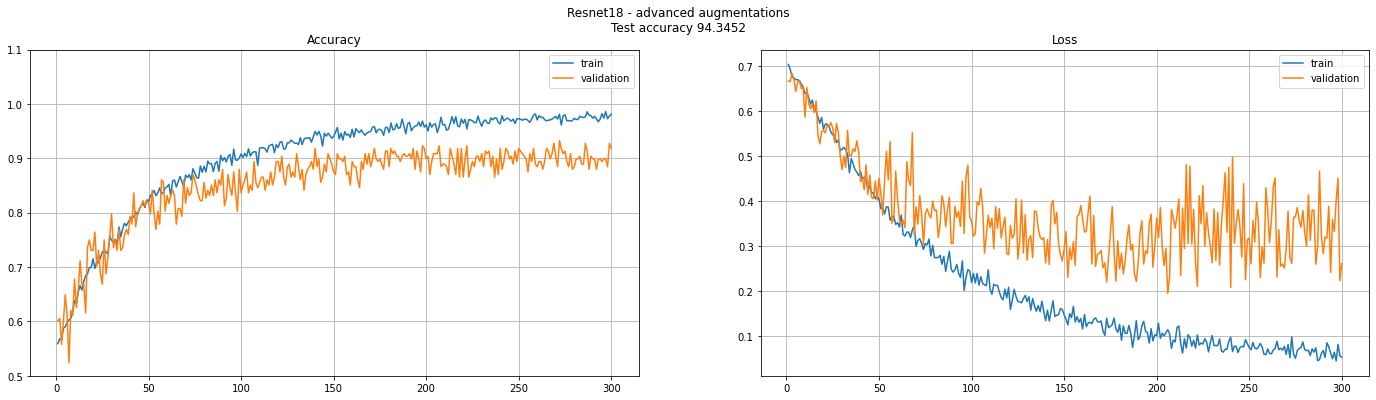

In [80]:
title = 'Resnet18 - advanced augmentations #test'
path_to_save = PATH_REPO_DRIVE 
# path_to_save = None

trainer.plot_history(title, path_to_save);